In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("/content/updated_pollution_dataset.csv")

# Exploratory Data Analysis

In [ ]:
df.head()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319,Moderate
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611,Moderate
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619,Moderate
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551,Good
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303,Good


In [ ]:
df.describe()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,30.029020,70.056120,20.142140,30.218360,26.412100,10.014820,1.500354,8.425400,497.423800
std,6.720661,15.863577,24.554546,27.349199,8.895356,6.750303,0.546027,3.610944,152.754084
min,13.400000,36.000000,0.000000,-0.200000,7.400000,-6.200000,0.650000,2.500000,188.000000
25%,25.100000,58.300000,4.600000,12.300000,20.100000,5.100000,1.030000,5.400000,381.000000
50%,29.000000,69.800000,12.000000,21.700000,25.300000,8.000000,1.410000,7.900000,494.000000
75%,34.000000,80.300000,26.100000,38.100000,31.900000,13.725000,1.840000,11.100000,600.000000
max,58.600000,128.100000,295.000000,315.800000,64.900000,44.900000,3.720000,25.800000,957.000000


In [ ]:
features = df.drop(columns="Air Quality")

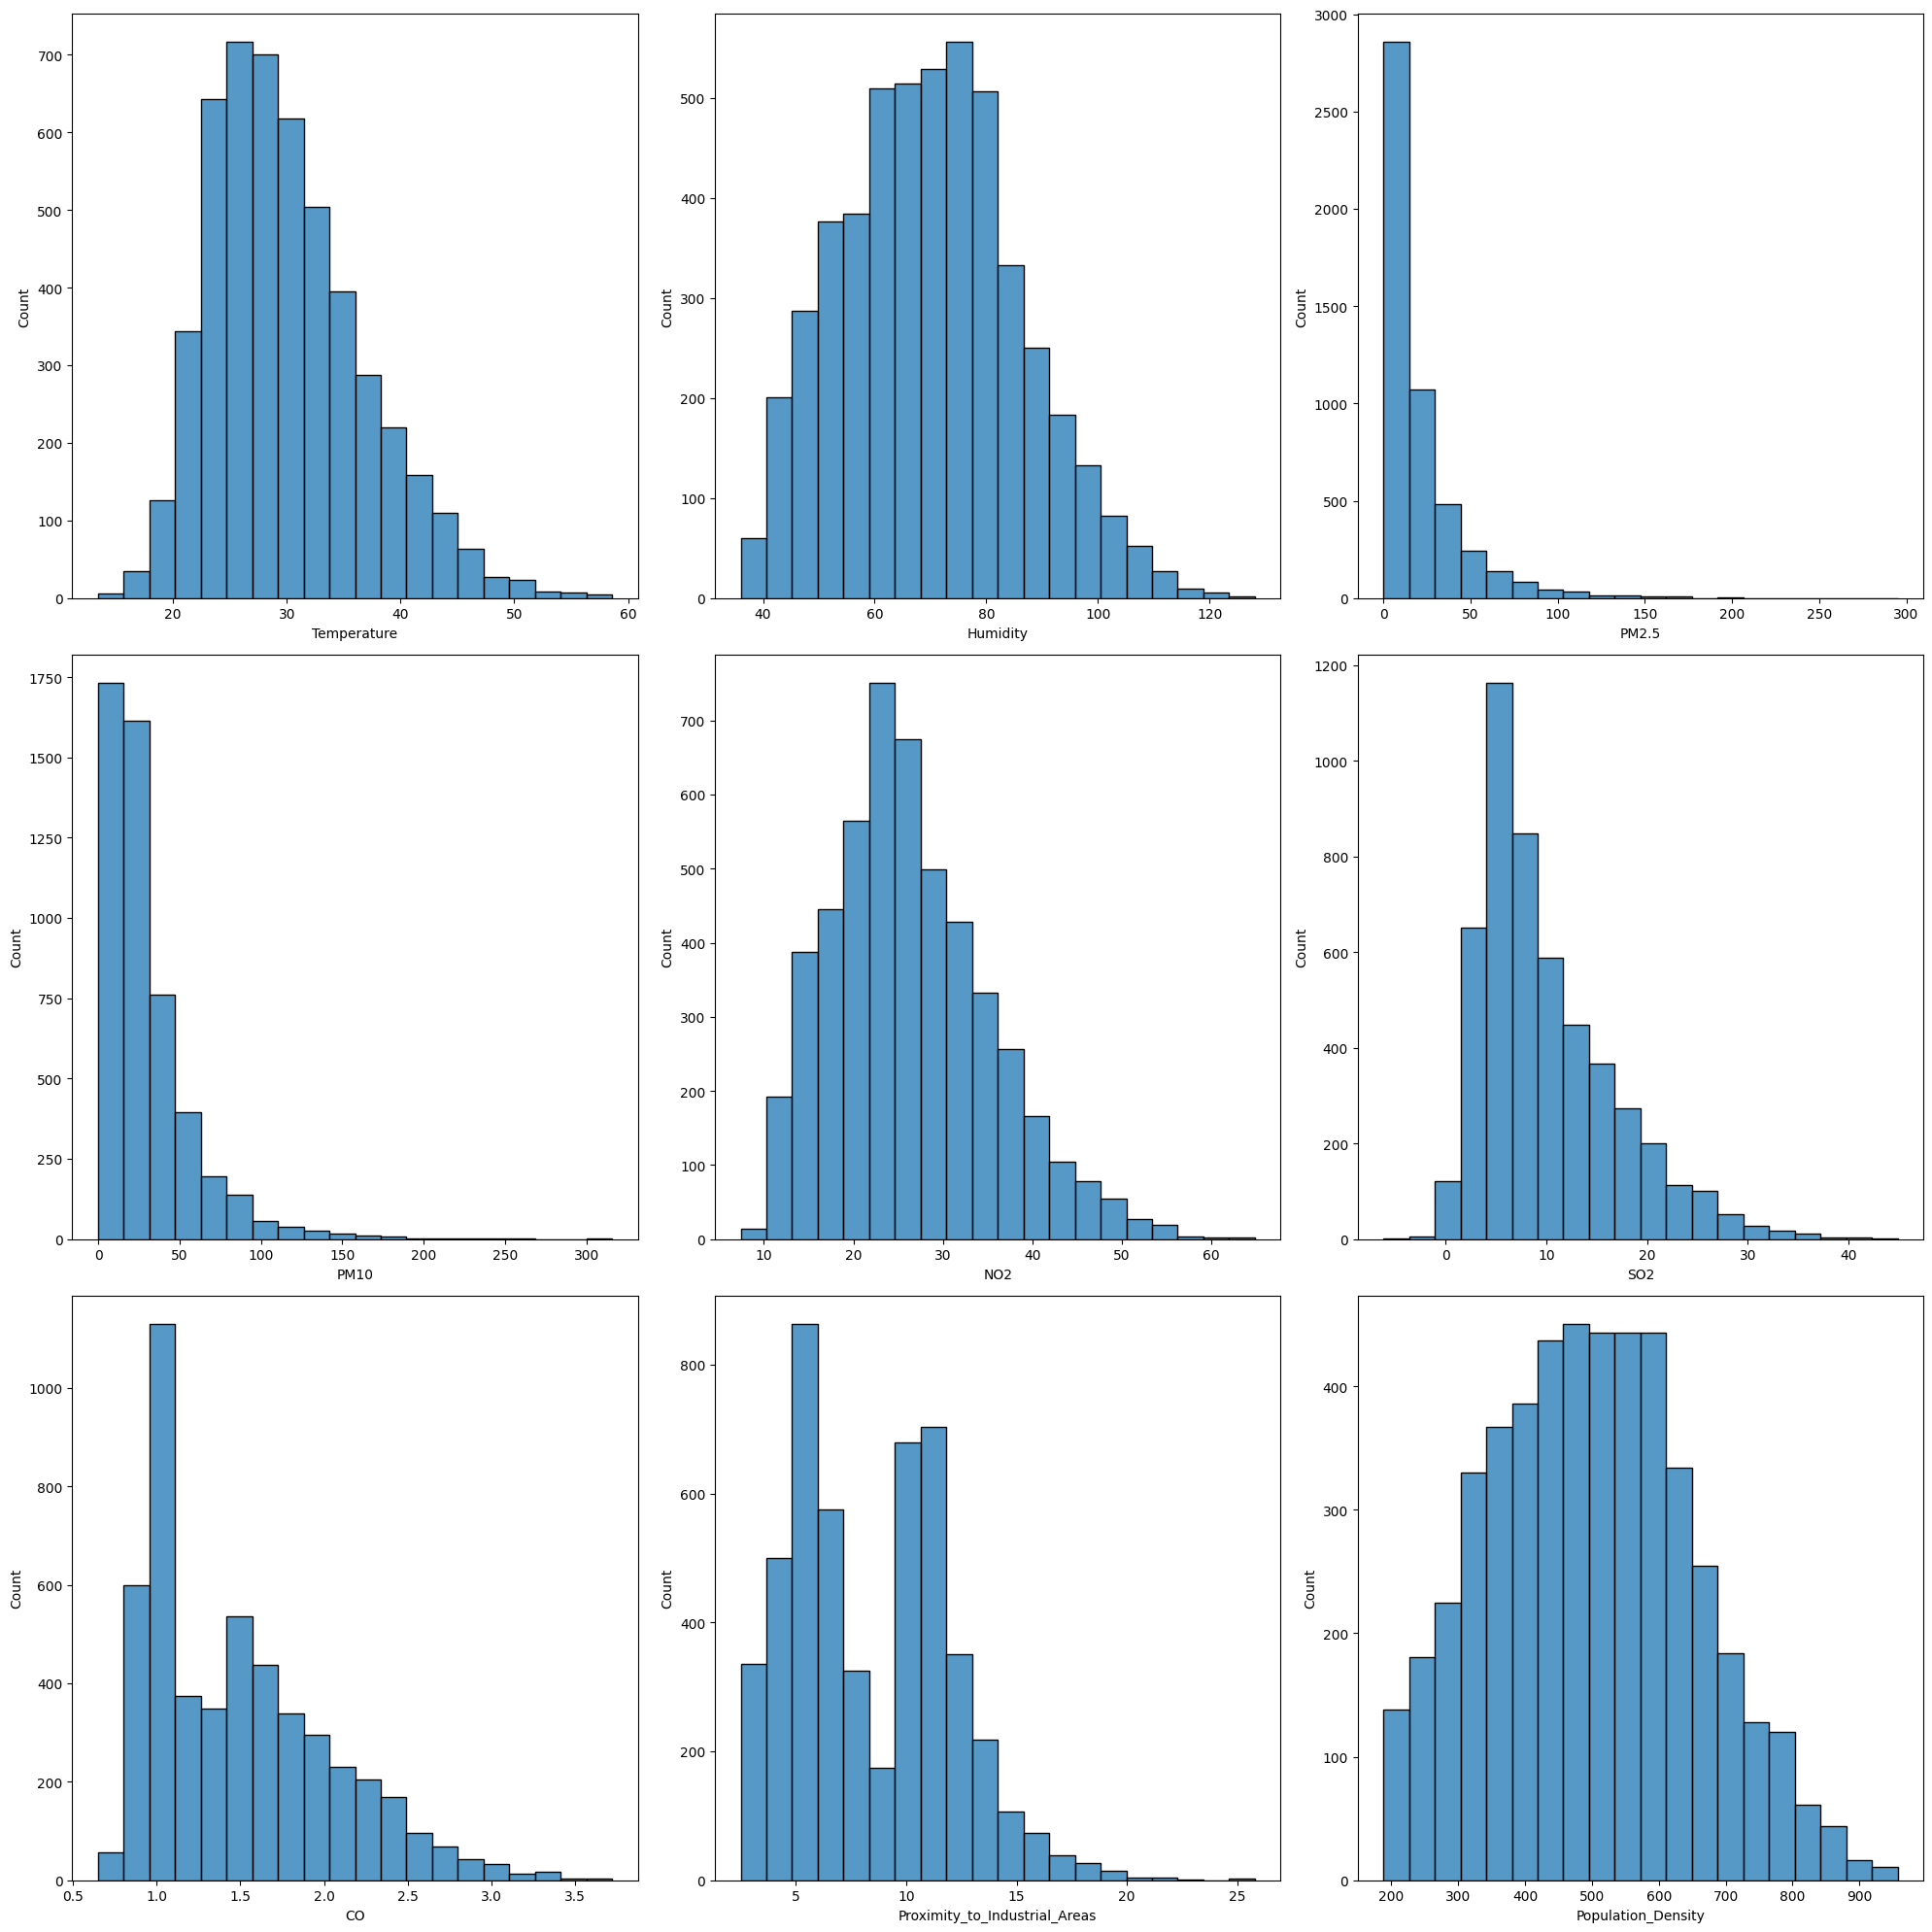

In [ ]:
plt.figure(figsize=[20, 20])
for i, col in enumerate(features):
    plt.subplot(3,3, i+1)
    sns.histplot(data=df, x=col, bins=20)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

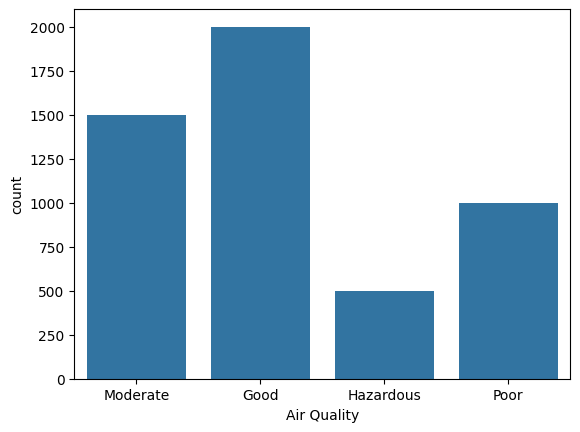

In [ ]:
sns.countplot(x="Air Quality", data=df)
plt.show()

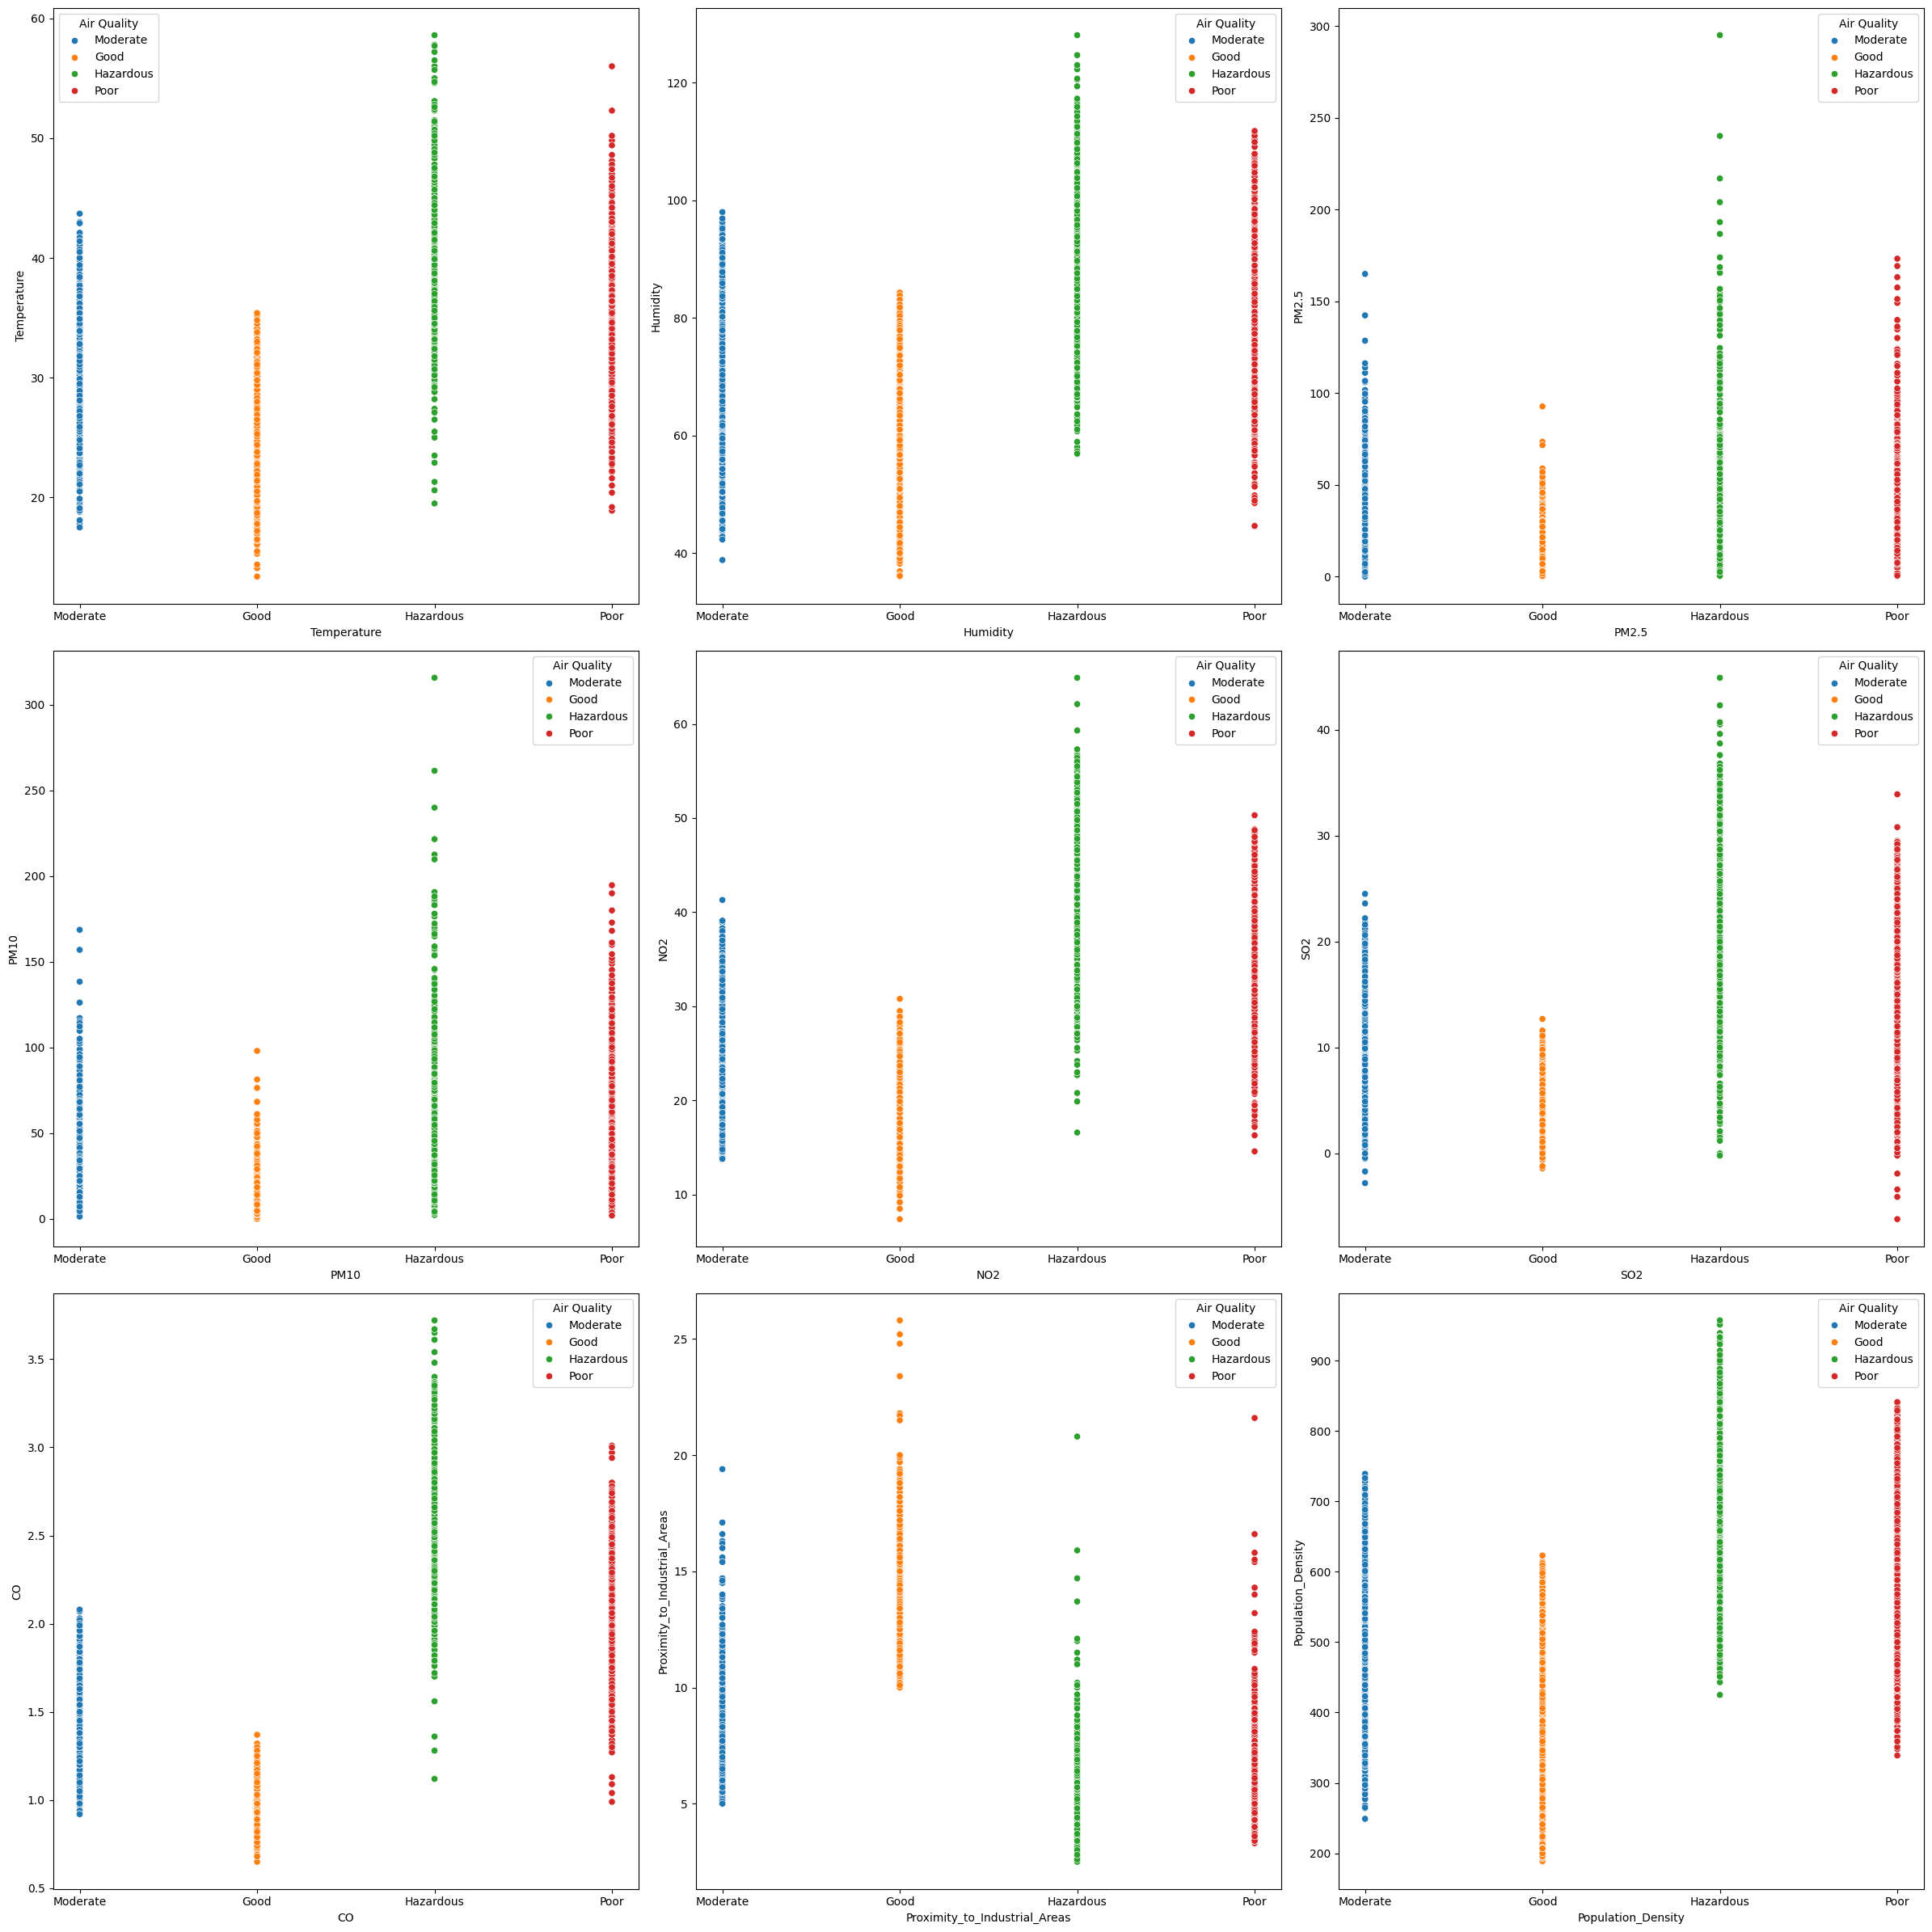

In [ ]:
plt.figure(figsize=[24,24])
for i, col in enumerate(features):
    plt.subplot(3,3,i+1)
    sns.scatterplot(data=df, x="Air Quality", y=col, hue="Air Quality")
    plt.xlabel(col)

plt.tight_layout()
plt.show()

# Data Preprocessing

In [ ]:
df.isnull().any()

,0
Temperature,False
Humidity,False
PM2.5,False
PM10,False
NO2,False
SO2,False
CO,False
Proximity_to_Industrial_Areas,False
Population_Density,False
Air Quality,False


In [ ]:
df.duplicated().any()

False

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
y = df["Air Quality"]
x = df.drop(columns="Air Quality")
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(4000, 9) (1000, 9) (4000,) (1000,)


# Ordinal Logistic Regression

In [ ]:
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.preprocessing import StandardScaler

In [ ]:
import statsmodels.api as sm

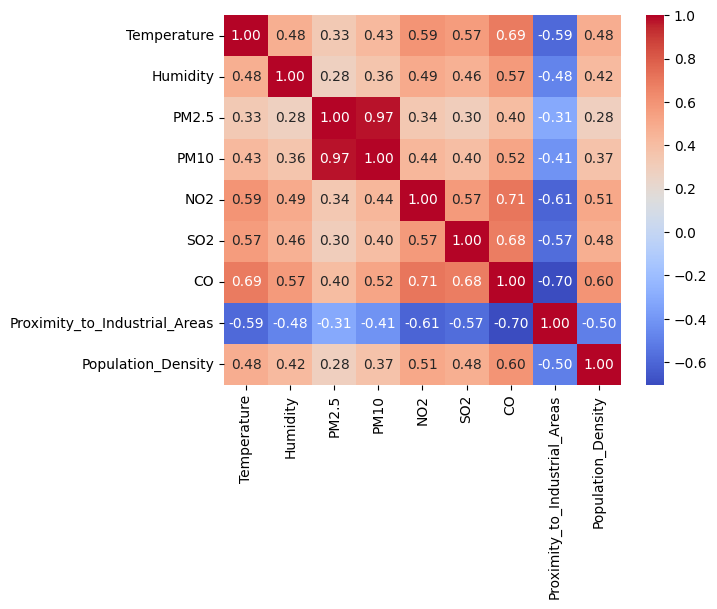

In [ ]:
#Check correlation of variables with each other to remove variables with very high correlations
correlation_matrix = x_train.corr(method="pearson")
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [ ]:
quality_map = {
    "Hazardous" : 0,
    "Poor" : 1,
    "Moderate" : 2,
    "Good" : 3
}
y_train_encoded = y_train.map(quality_map)
y_test_encoded = y_test.map(quality_map)

In [ ]:
#Logistic regression model does not perform well with too many features so remove a few.
features_reduced = features.drop(columns=["PM10", "SO2", "CO"])

for col in features_reduced:
  #Convert to normal distribution
  features_reduced[col] = features_reduced[col].clip(lower=0)
  features_reduced[col] = np.log1p(features_reduced[col])

x_train_reduced, x_test_reduced, y_train, y_test = train_test_split(features_reduced, y, test_size=0.2, random_state=1)

In [ ]:
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train_reduced)
x_test_scaled = scaler.fit_transform(x_test_reduced)

In [ ]:
model = OrderedModel(y_train_encoded, x_train_scaled, distr="logit")

model_fitted = model.fit(maxiter=5000)

print(model_fitted.summary())

Optimization terminated successfully.
         Current function value: 0.457166
         Iterations: 2616
         Function evaluations: 3704
                             OrderedModel Results                             
Dep. Variable:            Air Quality   Log-Likelihood:                -1828.7
Model:                   OrderedModel   AIC:                             3675.
Method:            Maximum Likelihood   BIC:                             3732.
Date:                Thu, 19 Dec 2024                                         
Time:                        12:25:01                                         
No. Observations:                4000                                         
Df Residuals:                    3991                                         
Df Model:                           6                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

In [ ]:
pred_probabilities_train = model_fitted.predict(x_train_scaled)
y_pred_train_logi = np.argmax(pred_probabilities_train, axis=1)

print("Train Accuracy: ", accuracy_score(y_train_encoded, y_pred_train_logi))

Train Accuracy:  0.8295


Testing Evalaution Metrics:
Test Accuracy:  0.821
Precision:  0.8159014296445277
Recall:  0.821
F1 Score:  0.8177791839614329

Classification Report: 
               precision    recall  f1-score   support

           0       0.72      0.64      0.68       100
           1       0.66      0.60      0.63       200
           2       0.78      0.81      0.80       296
           3       0.94      0.98      0.96       404

    accuracy                           0.82      1000
   macro avg       0.78      0.76      0.77      1000
weighted avg       0.82      0.82      0.82      1000


Confusion Matrix: 



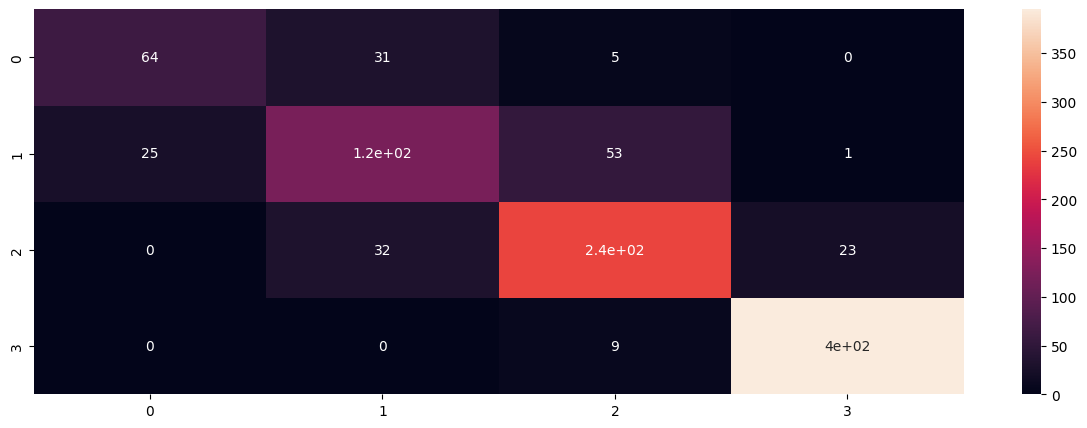

In [ ]:
pred_probabilities_test = model_fitted.predict(x_test_scaled)
y_pred_test_logi = np.argmax(pred_probabilities_test, axis=1)

print("Testing Evalaution Metrics:")
print("Test Accuracy: ", accuracy_score(y_test_encoded, y_pred_test_logi))
print("Precision: ",precision_score(y_test_encoded, y_pred_test_logi, average='weighted'))
print("Recall: ",recall_score(y_test_encoded, y_pred_test_logi, average='weighted'))
print("F1 Score: ", f1_score(y_test_encoded, y_pred_test_logi, average='weighted'))

print("\nClassification Report: \n",classification_report(y_test_encoded, y_pred_test_logi))
print("\nConfusion Matrix: \n")

plt.figure(figsize=(15,5))
sns.heatmap(confusion_matrix(y_test_encoded, y_pred_test_logi),annot=True)
plt.show()


# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
f1_score, classification_report, confusion_matrix

In [ ]:
#Finding the optimal depth of the tree
tree_param = {'max_depth': range(1, 21)}  # Checking depths from 1 to 20

dt = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(dt,tree_param,scoring='accuracy')

grid_search.fit(x_train, y_train)

print("Best max_depth:", grid_search.best_params_['max_depth'])

Best max_depth: 13


In [ ]:
final_model = DecisionTreeClassifier(max_depth=12, random_state=42)

final_model.fit(x_train, y_train)

y_pred_dt = final_model.predict(x_test)

print("Accuracy of Decision Tree Classifier: ", accuracy_score(y_test, y_pred_dt))
print("Precision of Decision Tree Classifier: ", precision_score(y_test, y_pred_dt, average='weighted'))
print("Recall of Decision Tree Classifier: ", recall_score(y_test, y_pred_dt, average='weighted'))
print("F1-Score of Decision Tree Classifier: ", f1_score(y_test, y_pred_dt, average='weighted'))

print(classification_report(y_test, y_pred_dt))

Accuracy of Decision Tree Classifier:  0.922
Precision of Decision Tree Classifier:  0.9222336662304105
Recall of Decision Tree Classifier:  0.922
F1-Score of Decision Tree Classifier:  0.9220856271406785
              precision    recall  f1-score   support

        Good       0.99      0.99      0.99       404
   Hazardous       0.84      0.83      0.83       100
    Moderate       0.92      0.93      0.92       296
        Poor       0.82      0.82      0.82       200

    accuracy                           0.92      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.92      0.92      0.92      1000



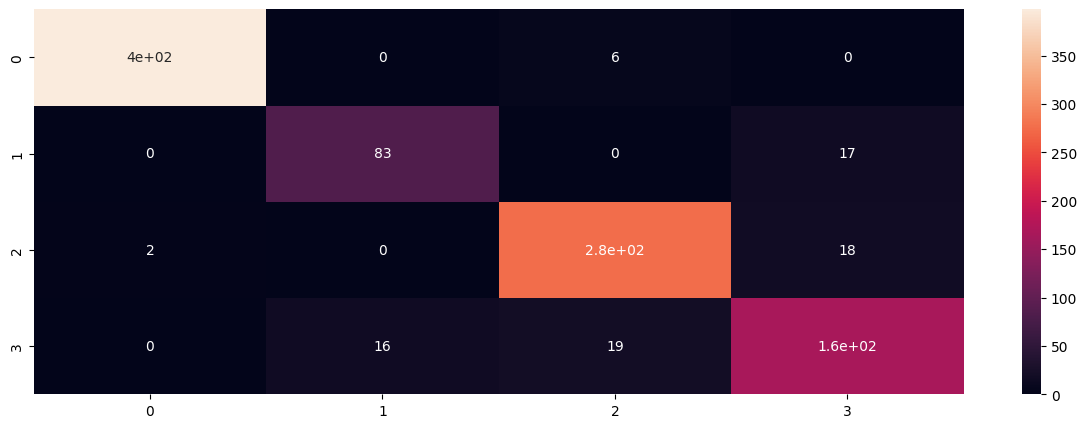

In [ ]:
plt.figure(figsize=(15,5))
sns.heatmap(confusion_matrix(y_test, y_pred_dt),annot=True)
plt.show()

# Random Forest

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
rf = RandomForestClassifier(random_state=1)
params = {"criterion" : ["gini", "entropy"],
          "min_samples_leaf" : list(np.arange(2,20)),
          "min_samples_split" : list(np.arange(2,20)),
          "n_estimators" : [200, 250, 300, 350, 400],
          "max_features" : ["sqrt", "log2"]
          }

rf_clf = RandomizedSearchCV(rf, params, scoring="accuracy", random_state=1)

rf_clf.fit(x_train, y_train)
print(rf_clf.best_params_)
print(rf_clf.best_score_)

{'n_estimators': 400, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'gini'}
0.9532499999999999


In [ ]:
rf_clf = rf_clf.best_estimator_
rf_pred = rf_clf.predict(x_test)

Testing Evalaution Metrics:
Accuracy:  0.947
Precision:  0.9466004296455425
Recall:  0.947
F1 Score:  0.9465657440425652

Classification Report: 
               precision    recall  f1-score   support

        Good       1.00      1.00      1.00       404
   Hazardous       0.90      0.88      0.89       100
    Moderate       0.93      0.97      0.95       296
        Poor       0.89      0.85      0.87       200

    accuracy                           0.95      1000
   macro avg       0.93      0.92      0.93      1000
weighted avg       0.95      0.95      0.95      1000


Confusion Matrix: 



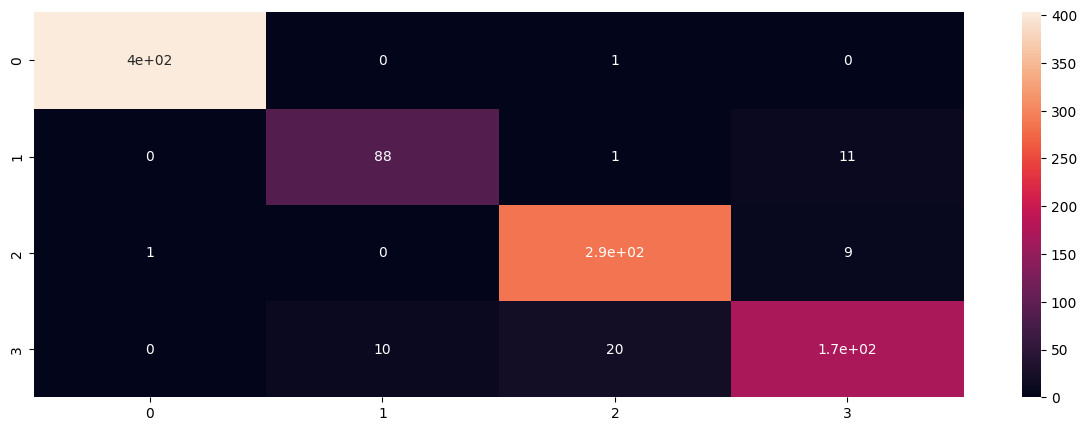

In [ ]:
print("Testing Evalaution Metrics:")
print("Accuracy: ",accuracy_score(y_test, rf_pred))
print("Precision: ",precision_score(y_test, rf_pred, average='weighted'))
print("Recall: ",recall_score(y_test, rf_pred, average='weighted'))
print("F1 Score: ", f1_score(y_test, rf_pred, average='weighted'))

print("\nClassification Report: \n",classification_report(y_test, rf_pred))
print("\nConfusion Matrix: \n")

plt.figure(figsize=(15,5))
sns.heatmap(confusion_matrix(y_test, rf_pred),annot=True)
plt.show()
